In [1]:
# 📌 Data Handling
import pandas as pd
import numpy as np

# 📊 Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# 📂 File Handling
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# 🧠 Preprocessing
from sklearn.preprocessing import LabelEncoder

# 🤖 Modeling - Scikit-learn
from sklearn.ensemble import (
    RandomForestClassifier,
    HistGradientBoostingClassifier,
    StackingClassifier
)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score

# 🚀 Modeling - XGBoost
from xgboost import XGBClassifier


/kaggle/input/c/titanic/train.csv
/kaggle/input/c/titanic/test.csv
/kaggle/input/c/titanic/gender_submission.csv
/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv


# 🚢 Titanic Survival Prediction – Ensemble Modeling Approach

In this notebook, we tackle the classic Titanic survival prediction problem using a structured and model-driven approach. Rather than relying on a single algorithm, we compare multiple machine learning models and ultimately combine them through ensembling to improve accuracy and generalization.

### 🧠 Key Steps in This Notebook:

1. **Data Cleaning & Feature Engineering**
   - Extract meaningful features such as `Title`, `FamilySize`, `IsAlone`, and `CabinLetter`
   - Encode categorical variables using label encoding
   - Handle missing values (e.g., imputing `Age` and `Fare` with the mean)

2. **Model Training**
   We train and evaluate three high-performing tree-based models:
   - **Random Forest** – A classic ensemble of decision trees using bagging
   - **XGBoost** – A gradient boosting model optimized for speed and performance
   - **HistGradientBoosting (HGB)** – A fast, histogram-based gradient boosting algorithm built into scikit-learn

3. **Model Ensembling (Stacking)**
   After comparing the performance of individual models, we combine them using a **stacking ensemble**:
   - The predictions of the base models (Random Forest, XGBoost, and HGB) are fed into a **Logistic Regression** meta-model
   - This stacked model learns to leverage the strengths of each base learner to produce a final prediction

4. **Final Prediction & Submission**
   - We train the ensemble model on the full training dataset
   - Predict outcomes on the test set
   - Submit results in the required format for the Titanic Kaggle competition
   - Current Best: 75% accuracy
   - 

**Whats Next**
To improve the accuracy score i have been rearching other approches to the problem and I plan on trying again in a new notebook and spending more time imputing the missing data rather than excluding rows with missing ages and finding a better solution than using the mean. 

* I will try MICE imputation as it seems more accurate. 
* I will use One Hot Encoding to simplify converting catagorical data to numeric for the ML models.
* I will stick to a single ML model, probably Random Forest



In [2]:

# 📂 Load the Datasets
train = pd.read_csv('/kaggle/input/titanic/train.csv')


# 🕵️ Step 3: Quick Glance
print("Train shape:", train.shape)
train.style.set_caption("Titanic Dataset Preview").background_gradient(cmap='Blues')
train.head(3)

Train shape: (891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [3]:
# 📋 Step 4: Summary Info
print("\n🧾 TRAIN INFO")
train.info()


🧾 TRAIN INFO
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [4]:
# 🧼 Step 6: Missing Values Check
print("Missing values in training set:\n", train.isnull().sum())


Missing values in training set:
 PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


there is alot of mising info for age and cabin numbers o we will not use these initialy. 

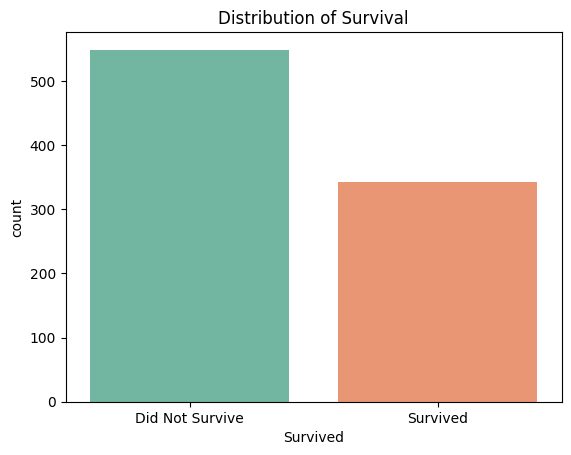

In [5]:
# 📈 Step 7: Target Variable Distribution
sns.countplot(x='Survived', data=train, palette='Set2')
plt.title('Distribution of Survival')
plt.xticks([0, 1], ['Did Not Survive', 'Survived'])
plt.show()

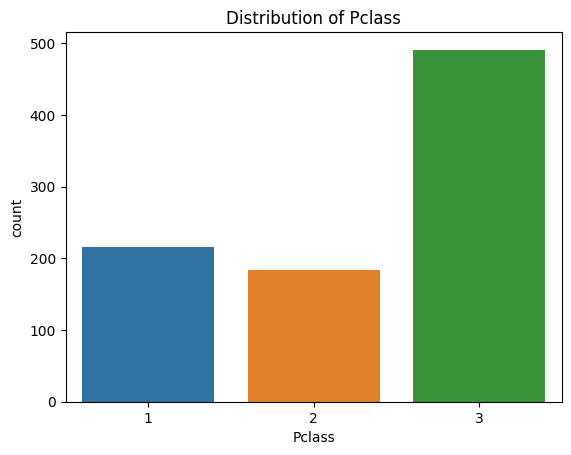

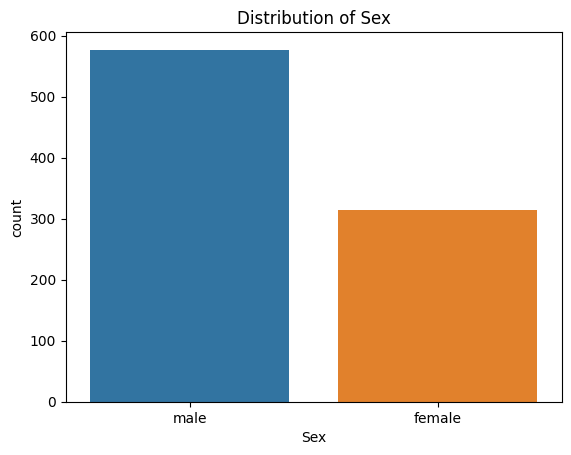

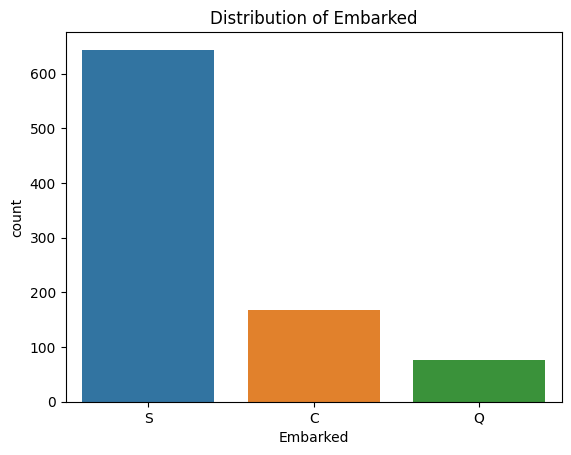

In [6]:
# 👀 Step 8: Categorical Feature Overview
cat_features = ['Pclass', 'Sex', 'Embarked']
for col in cat_features:
    sns.countplot(x=col, data=train)
    plt.title(f'Distribution of {col}')
    plt.show()

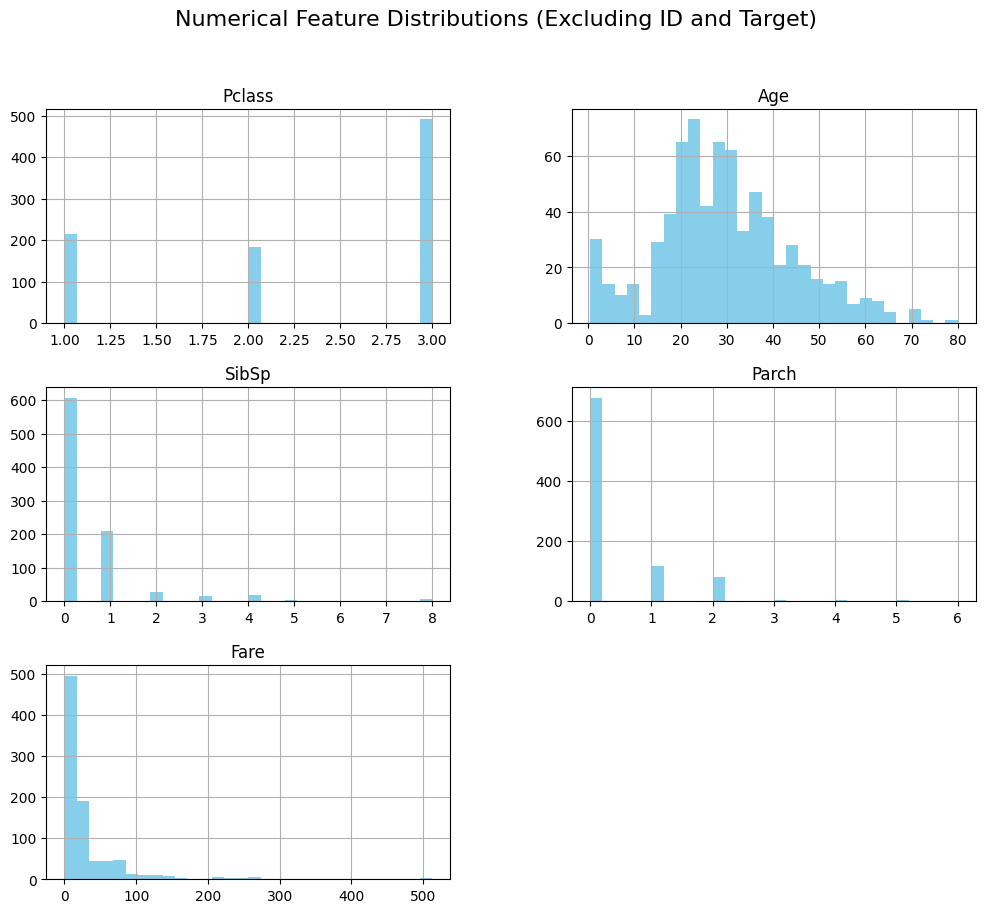

In [7]:
# 📉 Step 9: Numerical Feature Histograms (excluding PassengerId and Survived)
cols_to_plot = [col for col in train.select_dtypes(include='number').columns if col not in ['PassengerId', 'Survived']]

train[cols_to_plot].hist(bins=30, figsize=(12, 10), color='skyblue')
plt.suptitle("Numerical Feature Distributions (Excluding ID and Target)", fontsize=16)
plt.show()

Now we have inspected the data have understand it we can start with the analysis. we can drop columns we wont use and convert strings like sex into boolean type 0/1

In [8]:
# List of columns to keep
keep_cols = ['PassengerId', 'Pclass', 'Sex', 'Age', 'Fare', 'Embarked']

# Filter the DataFrame
train_clean = train[keep_cols]

# Map Sex and Embarked to numeric for analysis 
train['Sex'] = train['Sex'].map({'male': 0, 'female': 1})
train['Embarked'] = train['Embarked'].map({'C': 0, 'Q': 1, 'S': 2})

# Preview the result
train_clean.head()

,PassengerId,Pclass,Sex,Age,Fare,Embarked
0,1,3,male,22.0,7.2500,S
1,2,1,female,38.0,71.2833,C
2,3,3,female,26.0,7.9250,S
3,4,1,female,35.0,53.1000,S
4,5,3,male,35.0,8.0500,S


most of the ML models cant accept data with null values so we need to remove the rows with any nulls in the key features we are keeping

In [9]:
# Define the features you're keeping
features = ['Pclass', 'Sex', 'Age', 'Fare', 'Embarked']

# Drop rows with missing values in those columns only
train_clean = train.dropna(subset=keep_cols)

# Check result
print("Original shape:", train.shape)
print("After dropping rows with missing required features:", train_clean.shape)

Original shape: (891, 12)
After dropping rows with missing required features: (712, 12)


# Random Forest Model

Validation Accuracy: 0.7762237762237763


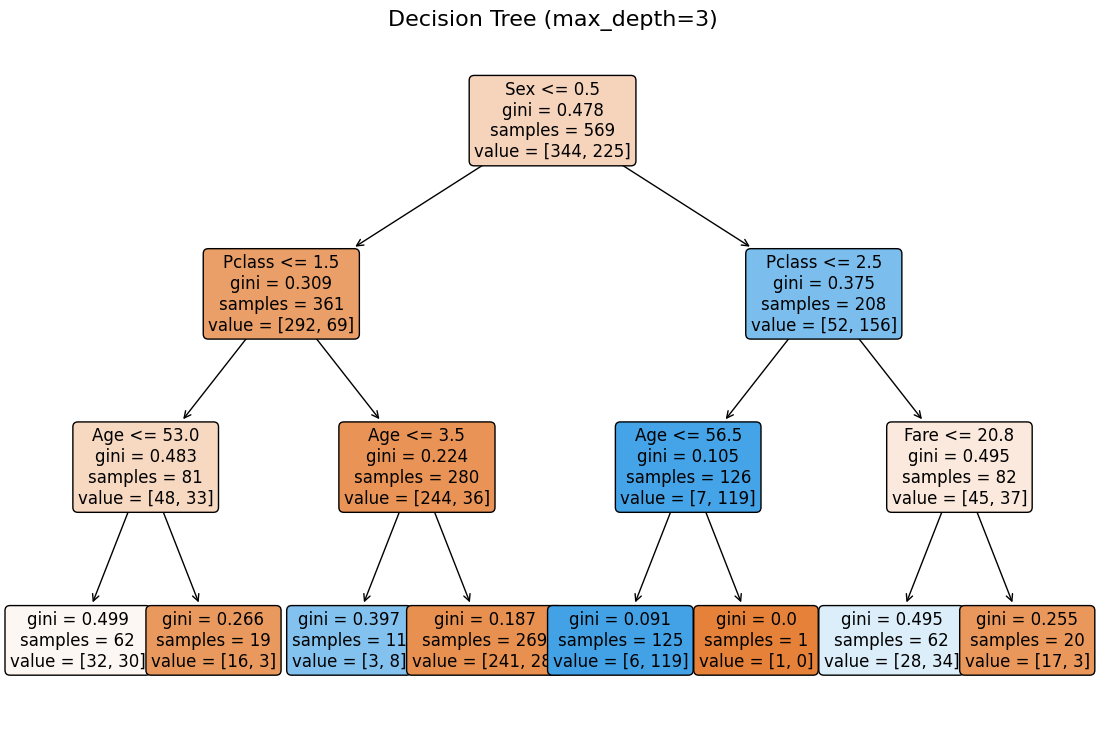

In [10]:
## Step 4: Prepare data for modeling
X = train_clean[features]
y = train_clean['Survived']

# Step 5: Train/test split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 6: Fit the model
model = RandomForestClassifier(n_estimators=500, random_state=42)
model.fit(X_train, y_train)

# Step 7: Predict and evaluate
y_pred = model.predict(X_val)
print("Validation Accuracy:", accuracy_score(y_val, y_pred))

# Plot Decision tree model
tree_model = DecisionTreeClassifier(max_depth=3, random_state=42)
tree_model.fit(X_train, y_train)

plt.figure(figsize=(14, 9))  # Wider and taller
plot_tree(tree_model, feature_names=features, filled=True, rounded=True, fontsize=12)
plt.title("Decision Tree (max_depth=3)", fontsize=16)
plt.show()




now do grid search feeature engineering to find optimal settings 

In [11]:
### 🚫 Skipping this heavy block (GridSearchCV) for now

#feature engineering grid to find best combination for max accuracy score


param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [4, 6, 8, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
}

# grid = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5)
# grid.fit(X_train, y_train)

# print("Best Params:", grid.best_params_)
# print("Best CV Score:", grid.best_score_)

redoing the random tree analysis using optiised features from the grid search improves accuracy from 77 to 79%

In [12]:
# Redoing random tree analysis using optimised features  
# ✅ Step 1: Define your optimized feature set (example: add FamilySize and Title if you’ve created them)
features = ['Pclass', 'Sex', 'Age', 'Fare', 'Embarked']  # Add engineered features here if available

# ✅ Step 2: Prepare training data
X = train_clean[features]
y = train_clean['Survived']

# ✅ Step 3: Train/Validation Split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# ✅ Step 4: Train Optimized Random Forest Model
model = RandomForestClassifier(
    n_estimators=100,
    max_depth=8,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42
)
model.fit(X_train, y_train)

# ✅ Step 5: Evaluate Accuracy
y_pred = model.predict(X_val)
print("🌲 Random Forest Validation Accuracy:", round(accuracy_score(y_val, y_pred), 4))

🌲 Random Forest Validation Accuracy: 0.7902


# XGBoost Model
initial running of xgbclassifier model with default settings gives 80% accuracy, already improved over random forest. 

📊 XGBoost Validation Accuracy: 0.8042


/tmp/ipykernel_13/2063082079.py:37: UserWarning: Glyph 129504 (\N{BRAIN}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129504 (\N{BRAIN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


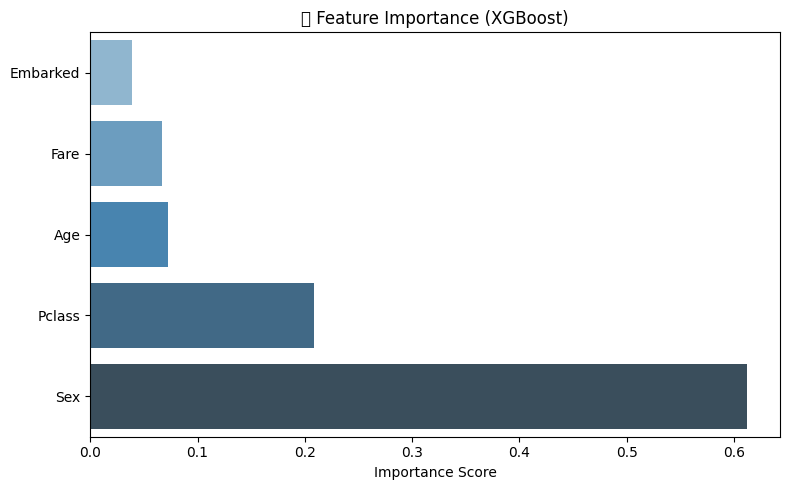

In [13]:
# Final optimized feature list — add more engineered features here if you have them
features = ['Pclass', 'Sex', 'Age', 'Fare', 'Embarked']  # Add Title, FamilySize, IsAlone if created

# X and y from clean data
X = train_clean[features]
y = train_clean['Survived']

# Train/Validation split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Build and fit the model
xgb_model = XGBClassifier(
    n_estimators=100,
    max_depth=4,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

xgb_model.fit(X_train, y_train)

# Predict on validation set
y_pred = xgb_model.predict(X_val)
print("📊 XGBoost Validation Accuracy:", round(accuracy_score(y_val, y_pred), 4))

# Get feature importance
importance_df = pd.Series(xgb_model.feature_importances_, index=features).sort_values(ascending=True)

# Plot
plt.figure(figsize=(8, 5))
sns.barplot(x=importance_df, y=importance_df.index, palette='Blues_d')
plt.title("🧠 Feature Importance (XGBoost)")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()

feature importance score shows that being a woman is by far the largest predictor of survival with being 1st class the second biggest predictor. 

Grid Search feature tuning of XGBoost to find optimised features 

In [14]:
### 🚫 Skipping this heavy block (GridSearchCV) for now

param_grid = {
    'n_estimators': [100, 200, 300, 500],                
    'max_depth': [3, 4, 5, 6],                          
    'learning_rate': [0.01, 0.05, 0.1, 0.2],             
    'subsample': [0.6, 0.8, 1.0],                          
    'colsample_bytree': [0.6, 0.8, 1.0]                 
}
#xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

#grid = GridSearchCV(
#    estimator=xgb,
#    param_grid=param_grid,
#    scoring='accuracy',
#    cv=5,
#    verbose=1,
#    n_jobs=-1
#)
#grid.fit(X_train, y_train)

#print("✅ Best Parameters:", grid.best_params_)
#print("🏆 Best Cross-Validation Accuracy:", round(grid.best_score_, 4))

using the optimised features from grid search rerun xgboost mdoel gives 81% accuracy 

In [15]:
# Final optimized feature list — add more engineered features here if you have them
features = ['Pclass', 'Sex', 'Age', 'Fare', 'Embarked']  # Add Title, FamilySize, IsAlone if created

# X and y from clean data
X = train_clean[features]
y = train_clean['Survived']

# Train/Validation split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Build and fit the model
xgb_model = XGBClassifier(
    n_estimators=500,
    max_depth=6,
    learning_rate=0.01,
    subsample=1.0,
    colsample_bytree=1.0,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

xgb_model.fit(X_train, y_train)

# Predict on validation set
y_pred = xgb_model.predict(X_val)
print("📊 XGBoost Validation Accuracy:", round(accuracy_score(y_val, y_pred), 4))


📊 XGBoost Validation Accuracy: 0.8112


XGBClassifier (Extreme Gradient Boosting)
	•	✅ GradientBoostingClassifier
	•	✅ LogisticRegression (a solid baseline)
	•	✅ HistGradientBoostingClassifier (handles NaNs

# HistGradientBoostingClassifier 
third model is third model is HistGradientBoostingClassifier.  This model can handel nulls so we can add back in some of the features with incomplete datasets like cabin number or age etc. 

In [16]:
hgb_model = HistGradientBoostingClassifier(
    learning_rate=0.01,
    max_depth=6,
    max_iter=500,          # Equivalent to n_estimators
    max_leaf_nodes=None,   
    l2_regularization=0.0, 
    early_stopping=True,
    random_state=42
)
hgb_model.fit(X_train, y_train)
y_pred = hgb_model.predict(X_val)


print("📈 HistGradientBoosting Accuracy:", round(accuracy_score(y_val, y_pred), 4))

📈 HistGradientBoosting Accuracy: 0.7972


starting at 79% acccuracy we then do grid search again to optimise featutre settings 

In [17]:
### 🚫 Skipping this heavy block (GridSearchCV) for now

param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [4, 6, 8],
    'max_iter': [100, 300, 500],
    'l2_regularization': [0.0, 1.0, 5.0],
    'early_stopping': [False]  # Disable early stopping during grid search for consistency
}
#hgb = HistGradientBoostingClassifier(random_state=42)

#grid = GridSearchCV(
#    estimator=hgb,
#    param_grid=param_grid,
#    cv=5,
#    scoring='accuracy',
#    verbose=1,
#    n_jobs=-1
#)

#grid.fit(X_train, y_train)
#print("✅ Best Parameters:", grid.best_params_)
#print("🏆 Best Cross-Validation Accuracy:", round(grid.best_score_, 4))


In [18]:
# Final optimized feature list (same as XGBoost)
features = ['Pclass', 'Sex', 'Age', 'Fare', 'Embarked']

# Split the cleaned dataset
X = train_clean[features]
y = train_clean['Survived']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Build and fit the optimized HGB model
hgb_model = HistGradientBoostingClassifier(
    learning_rate=0.05,
    max_depth=8,
    max_iter=300,
    l2_regularization=5.0,
    early_stopping=False,
    random_state=42
)

hgb_model.fit(X_train, y_train)

# Predict on validation set
y_pred_hgb = hgb_model.predict(X_val)
print("📈 HistGradientBoosting Accuracy:", round(accuracy_score(y_val, y_pred_hgb), 4))

📈 HistGradientBoosting Accuracy: 0.8182


with optimised featues it goes to 81.8% accuracy 

improve model by adding in some enginerred features like title extracted from name column, if they are alone based on the sibling/spouse column etc  

In [19]:
#  Step 1: Copy original DataFrame
train_fe = train.copy()

# Step 1: Extract Title
train_fe['Title'] = train_fe['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)

# Step 2: Simplify rare titles
train_fe['Title'] = train_fe['Title'].replace(
    ['Lady', 'Countess', 'Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev',
     'Sir', 'Jonkheer', 'Dona'], 'Rare'
)
train_fe['Title'] = train_fe['Title'].replace({'Mlle': 'Miss', 'Ms': 'Miss', 'Mme': 'Mrs'})

# Step 3: Convert Title to numeric labels
le = LabelEncoder()
train_fe['Title'] = le.fit_transform(train_fe['Title'].astype(str))

#  Step 2.5: Convert to CategoricalDtype
# train_fe['Title'] = train_fe['Title'].astype('category')


#  Step 3: Create FamilySize and IsAlone
train_fe['FamilySize'] = train_fe['SibSp'] + train_fe['Parch'] + 1
train_fe['IsAlone'] = (train_fe['FamilySize'] == 1).astype(int)

# Step 4: Extract Cabin Letter
train_fe['CabinLetter'] = train_fe['Cabin'].fillna('U').astype(str).str[0]
train_fe['CabinLetter'] = train_fe['CabinLetter'].astype('category')
# Step 3: Convert Title to numeric labels
le = LabelEncoder()
train_fe['CabinLetter'] = le.fit_transform(train_fe['CabinLetter'].astype(str))

train_fe.head(3)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,FamilySize,IsAlone,CabinLetter
0,1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,NaN,2.0,2,2,0,8
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,C85,0.0,3,2,0,2
2,3,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,NaN,2.0,1,1,1,8


In [20]:
# Final optimized feature list (same as XGBoost)
features = [
    'Pclass',
    'Sex',
    'Age',
    'Fare',
    'Embarked',
    'Title',       # from Name
    'FamilySize',  # from SibSp + Parch
    "IsAlone",     # from family size
    'CabinLetter'  # from Cabin
]
# Split the cleaned dataset
X = train_fe[features]
y = train_fe['Survived']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Build and fit the optimized HGB model
hgb_model = HistGradientBoostingClassifier(
    learning_rate=0.05,
    max_depth=8,
    max_iter=300,
    l2_regularization=5.0,
    early_stopping=False,
    random_state=42
)

hgb_model.fit(X_train, y_train)

# Predict on validation set
y_pred_hgb = hgb_model.predict(X_val)
print("📈 HistGradientBoosting Accuracy:", round(accuracy_score(y_val, y_pred_hgb), 4))

📈 HistGradientBoosting Accuracy: 0.8324


redo the grid search as adding in these new features may effect the best optimisation. 

In [21]:
### 🚫 Skipping this heavy block (GridSearchCV) for now

#param_grid = {
#   'learning_rate': [0.01, 0.05, 0.1,],
#    'max_depth': [, 4, 6, 8],
#    'max_iter': [100, 300, 500],
#    'l2_regularization': [0.0, 1.0, 5.0],
#    'early_stopping': [False]  # Disable early stopping during grid search for consistency
#}
#hgb = HistGradientBoostingClassifier(random_state=42)

#grid = GridSearchCV(
#    estimator=hgb,
#    param_grid=param_grid,
#   cv=5,
#    scoring='accuracy',
#   verbose=1,
#   n_jobs=-1
#)

#grid.fit(X_train, y_train)
#print("✅ Best Parameters:", grid.best_params_)
#print("🏆 Best Cross-Validation Accuracy:", round(grid.best_score_, 4))


In [22]:
# Final optimized feature list (same as XGBoost)
features = [
    'Pclass',
    'Sex',
    'Age',
    'Fare',
    'Embarked',
    'Title',       # from Name
    'FamilySize',  # from SibSp + Parch
    "IsAlone",     # from family size
    'CabinLetter'  # from Cabin
]
# Split the cleaned dataset
X = train_fe[features]
y = train_fe['Survived']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Build and fit the optimized HGB model
hgb_model = HistGradientBoostingClassifier(
    learning_rate=0.1,
    max_depth=4,
    max_iter=300,
    l2_regularization=1.0,
    early_stopping=False,
    random_state=42
)

hgb_model.fit(X_train, y_train)

# Predict on validation set
y_pred_hgb = hgb_model.predict(X_val)
print("📈 HistGradientBoosting Accuracy:", round(accuracy_score(y_val, y_pred_hgb), 4))

📈 HistGradientBoosting Accuracy: 0.8212


this is lower than the previos optimisations so i will not use it. 

the final thing we can do to improve accuracy is conbine the 3 modele we have tried as an ensemble (stack) where they run parralel and the results are determuned by voting. 

In [23]:
# Drop the 'Cabin' and 'Embarked' columns
train_fe = train_fe.drop(columns=['Cabin'])

# Drop rows where Age is missing
train_fe = train_fe.dropna(subset=['Age', 'Embarked'])

train_fe.isna().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
Title          0
FamilySize     0
IsAlone        0
CabinLetter    0
dtype: int64

In [24]:
# Define the meta-model with more iterations
meta_model = LogisticRegression(max_iter=1000)

# ✅ Features and target
X = train_fe[features]
y = train_fe['Survived']

# ✅ Train/validation split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# ✅ Build the stack
stack = StackingClassifier(
    estimators=[
        ('xgb', XGBClassifier(
            n_estimators=500,
            learning_rate=0.01,
            max_depth=6,
            subsample=1.0,
            colsample_bytree=1.0,
            use_label_encoder=False,
            eval_metric='logloss',
            random_state=42
        )),
        ('rf', RandomForestClassifier(
            n_estimators=500,
            max_depth=6,
            random_state=42
        )),
        ('hgb', HistGradientBoostingClassifier(
            max_iter=300,
            learning_rate=0.05,
            max_depth=8,
            l2_regularization=5.0,
            early_stopping=False,
            random_state=42
        ))
    ],
    final_estimator=meta_model,
    passthrough=True
)

# ✅ Fit the stack
stack.fit(X_train, y_train)

# ✅ Predict and evaluate
y_pred_stack = stack.predict(X_val)
print("🔗 Stacking Ensemble Accuracy:", round(accuracy_score(y_val, y_pred_stack), 4))

🔗 Stacking Ensemble Accuracy: 0.7972


In [25]:
# ✅ Split the data
X = train_fe[features]
y = train_fe['Survived']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# ✅ Define base models with optimized hyperparameters
xgb_model = XGBClassifier(
    n_estimators=500,
    max_depth=6,
    learning_rate=0.01,
    subsample=1.0,
    colsample_bytree=1.0,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=8,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42
)

hgb_model = HistGradientBoostingClassifier(
    learning_rate=0.1,
    max_depth=4,
    max_iter=300,
    l2_regularization=1.0,
    early_stopping=False,
    random_state=42
)

# ✅ Final meta-model (can also experiment with stronger models here)
meta_model = LogisticRegression(max_iter=1000)

# ✅ Build stacking ensemble
stack = StackingClassifier(
    estimators=[
        ('xgb', xgb_model),
        ('rf', rf_model),
        ('hgb', hgb_model)
    ],
    final_estimator=meta_model,
    passthrough=True
)

# ✅ Fit and evaluate
stack.fit(X_train, y_train)
y_pred_stack = stack.predict(X_val)

print("📊 Stacking Ensemble Accuracy:", round(accuracy_score(y_val, y_pred_stack), 4))

📊 Stacking Ensemble Accuracy: 0.8112


 not the result i was expecting from the stocking model of 81% which is no better than the 80-82% i got with the xgb and hgb (optimised). the reasons the stackign may not have improved the accuracy may be because the base models where already optimied and the dataset for titanic is quite small (800)# 

# Cleaning test set and matching formating to train set

In [26]:
train = pd.read_csv('/kaggle/input/titanic/train.csv')
test = pd.read_csv('/kaggle/input/titanic/test.csv')

In [27]:
#  1. Convert 'Sex' from string to numeric
for df in [train, test]:
    df['Sex'] = df['Sex'].map({'male': 0, 'female': 1})

#  2. Extract Title and normalize uncommon titles
for df in [train, test]:
    df['Title'] = df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
    df['Title'] = df['Title'].replace(
        ['Lady', 'Countess', 'Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev',
         'Sir', 'Jonkheer', 'Dona'], 'Rare'
    )
    df['Title'] = df['Title'].replace({'Mlle': 'Miss', 'Ms': 'Miss', 'Mme': 'Mrs'})

#  3. Encode Title consistently across train and test
le_title = LabelEncoder()
combined_titles = pd.concat([train['Title'], test['Title']])
le_title.fit(combined_titles.astype(str))
train['Title'] = le_title.transform(train['Title'].astype(str))
test['Title'] = le_title.transform(test['Title'].astype(str))

#  4. Create FamilySize and IsAlone
for df in [train, test]:
    df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
    df['IsAlone'] = (df['FamilySize'] == 1).astype(int)

#  5. Extract CabinLetter and encode it
train['CabinLetter'] = train['Cabin'].fillna('U').astype(str).str[0]
test['CabinLetter'] = test['Cabin'].fillna('U').astype(str).str[0]

# Ensure all values are strings
train['CabinLetter'] = train['CabinLetter'].astype(str)
test['CabinLetter'] = test['CabinLetter'].astype(str)

# Encode CabinLetter consistently
combined_cabin = pd.concat([train['CabinLetter'], test['CabinLetter']])
le_cabin = LabelEncoder()
le_cabin.fit(combined_cabin)

train['CabinLetter'] = le_cabin.transform(train['CabinLetter'])
test['CabinLetter'] = le_cabin.transform(test['CabinLetter'])

#  6. Drop unused columns from both datasets
columns_to_drop = ['Embarked', 'Name', 'SibSp', 'Parch', 'Cabin', 'Ticket']
train = train.drop(columns=columns_to_drop, errors='ignore')
test = test.drop(columns=columns_to_drop, errors='ignore')

print("🔹 Train Data:")
print(train.head())

print("\n🔹 Test Data:")
print(test.head())

🔹 Train Data:
   PassengerId  Survived  Pclass  Sex   Age     Fare  Title  FamilySize  \
0            1         0       3    0  22.0   7.2500      2           2   
1            2         1       1    1  38.0  71.2833      3           2   
2            3         1       3    1  26.0   7.9250      1           1   
3            4         1       1    1  35.0  53.1000      3           2   
4            5         0       3    0  35.0   8.0500      2           1   

   IsAlone  CabinLetter  
0        0            8  
1        0            2  
2        1            8  
3        0            2  
4        1            8  

🔹 Test Data:
   PassengerId  Pclass  Sex   Age     Fare  Title  FamilySize  IsAlone  \
0          892       3    0  34.5   7.8292      2           1        1   
1          893       3    1  47.0   7.0000      3           2        0   
2          894       2    0  62.0   9.6875      2           1        1   
3          895       3    0  27.0   8.6625      2           1        

In [28]:
# Fill Age and Fare in train
train['Age'] = train['Age'].fillna(train['Age'].mean())
train['Fare'] = train['Fare'].fillna(train['Fare'].mean())

# Fill Age and Fare in test
test['Age'] = test['Age'].fillna(train['Age'].mean())  # use train mean for consistency
test['Fare'] = test['Fare'].fillna(train['Fare'].mean())  # same here

# Final optimized feature list (same as XGBoost)
features = [
    'Pclass',
    'Sex',
    'Age',
    'Fare',
    'Title',       # from Name
    'FamilySize',  # from SibSp + Parch
    "IsAlone",     # from family size
    'CabinLetter'  # from Cabin
]

# use the full training set and test the test set
X_train = train[features]
y_train = train['Survived']
X_test = test[features]  # `test_fe` should be your cleaned, feature-engineered test DataFrame


print("✅ test rows:", len(test))
print("✅ X_test rows:", len(X_test))
print(X_test.isna().sum())
print("✅ train rows:", len(train))
print("✅ X_train rows:", len(X_train))
print(X_train.isna().sum())

✅ test rows: 418
✅ X_test rows: 418
Pclass         0
Sex            0
Age            0
Fare           0
Title          0
FamilySize     0
IsAlone        0
CabinLetter    0
dtype: int64
✅ train rows: 891
✅ X_train rows: 891
Pclass         0
Sex            0
Age            0
Fare           0
Title          0
FamilySize     0
IsAlone        0
CabinLetter    0
dtype: int64


In [29]:
# Build and fit the optimized HGB model
hgb_model = HistGradientBoostingClassifier(
    learning_rate=0.05,
    max_depth=8,
    max_iter=300,
    l2_regularization=5.0,
    early_stopping=False,
    random_state=42
)

hgb_model.fit(X_train, y_train)

# Predict on validation set
y_pred_hgb = hgb_model.predict(X_test)
print("Prediction count:", len(y_pred_hgb))


Prediction count: 418


In [30]:


submission = pd.DataFrame({
    'PassengerId': test['PassengerId'],
    'Survived': y_pred_hgb
})
submission.to_csv('submission.csv', index=False)
submission.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


In [31]:
# Add Survived predictions to the test DataFrame
test['Survived'] = y_pred_hgb

# Save the full test data with predictions
test.to_csv('test_data_outcome.csv', index=False)

# Preview the result
test.head()

,PassengerId,Pclass,Sex,Age,Fare,Title,FamilySize,IsAlone,CabinLetter,Survived
0,892,3,0,34.5,7.8292,2,1,1,8,0
1,893,3,1,47.0,7.0000,3,2,0,8,0
2,894,2,0,62.0,9.6875,2,1,1,8,0
3,895,3,0,27.0,8.6625,2,1,1,8,0
4,896,3,1,22.0,12.2875,3,3,0,8,1
